In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, GlobalMaxPool1D, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from keras.utils import to_categorical

In [2]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [3]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/NLPFinalProject/Dataset.csv")
df.head()

,Unnamed: 0.1,Unnamed: 0,Generation,label
0,0,0,latest headlines on cnn business - google's go...,gpt2
1,1,1,china wants to take a victory lap over its han...,gpt2
2,2,2,coronavirus disinformation creates challenges ...,gpt2
3,3,3,china coronavirus: eating wild animals made il...,gpt2
4,4,4,china's economy could shrink for the first tim...,gpt2


In [4]:
df.shape

(11726, 4)

In [5]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Generation', 'label'], dtype='object')

In [6]:
df.drop('Unnamed: 0.1', axis=1, inplace=True) 

In [7]:
df.drop('Unnamed: 0', axis=1, inplace=True) 

In [8]:
df.head()

,Generation,label
0,latest headlines on cnn business - google's go...,gpt2
1,china wants to take a victory lap over its han...,gpt2
2,coronavirus disinformation creates challenges ...,gpt2
3,china coronavirus: eating wild animals made il...,gpt2
4,china's economy could shrink for the first tim...,gpt2


In [9]:
df['len'] = df['Generation'].apply(lambda x: len(x.split(" ")))
df.head()

,Generation,label,len
0,latest headlines on cnn business - google's go...,gpt2,405
1,china wants to take a victory lap over its han...,gpt2,415
2,coronavirus disinformation creates challenges ...,gpt2,431
3,china coronavirus: eating wild animals made il...,gpt2,432
4,china's economy could shrink for the first tim...,gpt2,429


In [10]:
df['label'].value_counts()

gpt2           1066
instructgpt    1066
human          1066
xlnet          1066
fair           1066
gpt            1066
ctrl           1066
pplm           1066
grover         1066
gpt3           1066
xlm            1066
Name: label, dtype: int64

In [11]:
df['label'] = df['label'].replace({'gpt2': 0, 'instructgpt': 1, 'human': 2,'xlnet': 3,'fair': 4,'gpt': 5,'ctrl': 6,'pplm': 7,'grover': 8, 'gpt3': 9, 'xlm': 10})

In [12]:
df['label'].value_counts()

0     1066
1     1066
2     1066
3     1066
4     1066
5     1066
6     1066
7     1066
8     1066
9     1066
10    1066
Name: label, dtype: int64

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_data = df['Generation']

In [15]:
y_data = df['label']

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X_data,y_data, test_size=0.2, random_state=42, shuffle=True)

In [17]:
y_train

10190     9
8969      8
2592      2
2471      2
5272      4
         ..
11284    10
5191      4
5390      5
860       0
7270      6
Name: label, Length: 9380, dtype: int64

In [18]:
from keras.utils import to_categorical

In [19]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout,GlobalMaxPool1D, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential

In [20]:
max_features = 88088
maxlen = 50
embedding_size = 200

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
tfidf_vectorizer.fit(x_train)

X_train_tfidf = tfidf_vectorizer.transform(x_train)
X_test_tfidf = tfidf_vectorizer.transform(x_test)


In [31]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-05-09 04:55:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-09 04:55:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-09 04:55:32--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [32]:
glove_file = '/content/drive/MyDrive/NLPFinalProject/NLP Project/glove.6B.zip'

In [33]:
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

In [34]:
EMBEDDING_FILE = '/content/glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    embeddings[word] = embd


embedding_matrix_tfidf = np.zeros((max_features, 200))

for word, index in tfidf_vectorizer.vocabulary_.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix_tfidf[index] = embedding_vector * tfidf_vectorizer.idf_[index]


In [37]:
def texts_to_sequences(texts, vocabulary):
    sequences = []
    for text in texts:
        sequence = []
        for word in text.split():
            index = vocabulary.get(word)
            if index is not None:
                sequence.append(index)
        sequences.append(sequence)
    return sequences

X_train_indices = texts_to_sequences(x_train, tfidf_vectorizer.vocabulary_)
X_test_indices = texts_to_sequences(x_test, tfidf_vectorizer.vocabulary_)

In [38]:
X_train_padded = pad_sequences(X_train_indices, maxlen=maxlen)
X_test_padded = pad_sequences(X_test_indices, maxlen=maxlen)

In [ ]:
len(embeddings.values())

400000

In [ ]:
embedding_size

200

In [39]:
from tensorflow.keras.layers import GlobalMaxPooling1D, BatchNormalization

In [40]:
# Preprocess output data
y_tra = np.asarray(y_train)
y_tra = y_tra[:, np.newaxis]  # add a new axis to make it 2D
y_one_hot_train = to_categorical(y_tra, num_classes=11)

In [41]:
y_tes = np.asarray(y_test)
y_tes = y_tes[:, np.newaxis]  # add a new axis to make it 2D
y_one_hot_tes = to_categorical(y_tes, num_classes=11)

In [ ]:
from tensorflow.keras.layers import Dropout

In [ ]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen, weights=[embedding_matrix_tfidf]))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(11, activation="softmax"))


# compile and train the model
batch_size = 64
epochs = 30
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train_padded, y_one_hot_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/30
118/118 [==============================] - 36s 198ms/step - loss: 1.6404 - accuracy: 0.4324 - val_loss: 1.5654 - val_accuracy: 0.5160
Epoch 2/30
118/118 [==============================] - 16s 132ms/step - loss: 1.1683 - accuracy: 0.5772 - val_loss: 1.2609 - val_accuracy: 0.5752
Epoch 3/30
118/118 [==============================] - 12s 102ms/step - loss: 0.9581 - accuracy: 0.6493 - val_loss: 1.0986 - val_accuracy: 0.6381
Epoch 4/30
118/118 [==============================] - 9s 71ms/step - loss: 0.8263 - accuracy: 0.6950 - val_loss: 1.0539 - val_accuracy: 0.6290
Epoch 5/30
118/118 [==============================] - 9s 78ms/step - loss: 0.7032 - accuracy: 0.7401 - val_loss: 1.0091 - val_accuracy: 0.6290
Epoch 6/30
118/118 [==============================] - 7s 58ms/step - loss: 0.6192 - accuracy: 0.7748 - val_loss: 0.9135 - val_accuracy: 0.6716
Epoch 7/30
118/118 [==============================] - 7s 61ms/step - loss: 0.4987 - accuracy: 0.8209 - val_loss: 0.9256 - val_accuracy: 

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

In [ ]:
# evaluate the model
_, train_acc = model.evaluate(X_train_padded, y_one_hot_train, verbose=0)
_, test_acc = model.evaluate(X_test_padded, y_one_hot_tes, verbose=0)

In [ ]:
from matplotlib import pyplot

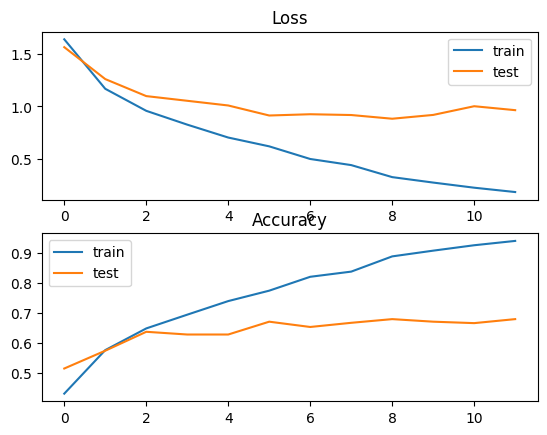

In [ ]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
predictions = model.predict(X_test_padded)

74/74 [==============================] - 2s 9ms/step


In [ ]:
predictions

array([[2.0191120e-02, 9.0314780e-04, 3.9839229e-04, ..., 2.9418166e-03,
        2.4560464e-03, 1.1698323e-04],
       [2.1742750e-03, 4.5929491e-04, 1.2763639e-03, ..., 5.1777000e-03,
        2.8021267e-04, 1.3706156e-03],
       [2.0690227e-03, 8.2329285e-01, 1.8927606e-02, ..., 5.9433421e-03,
        1.4178000e-01, 1.2532278e-04],
       ...,
       [1.3850003e-03, 1.9977022e-02, 9.2245781e-01, ..., 2.8490718e-02,
        1.7330244e-02, 2.3233695e-03],
       [2.8914280e-04, 1.0036057e-04, 8.8568323e-04, ..., 2.9157489e-04,
        1.3886511e-04, 6.2655614e-05],
       [3.3364393e-02, 1.7052302e-01, 3.2479087e-01, ..., 2.1991855e-01,
        1.2772352e-01, 1.1451729e-02]], dtype=float32)

In [ ]:
y_pred_one_hot = np.argmax(predictions, axis=1)
y_test_one_hot = np.argmax(y_one_hot_tes, axis=1)

In [ ]:
f1_macro = f1_score(y_test_one_hot, y_pred_one_hot, average="macro")

print("F1 macro score:", f1_macro)

F1 macro score: 0.6845967652097157


In [ ]:
# Evaluate the model
_, train_acc = model.evaluate(X_train_padded, y_one_hot_train, verbose=0)
_, test_acc = model.evaluate(X_test_padded, y_one_hot_tes, verbose=0)

print("Train accuracy:", train_acc)
print("Test accuracy:", test_acc)

Train accuracy: 0.8682302832603455
Test accuracy: 0.6828644275665283


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.7 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import tensorflow as tf

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def convert_examples_to_features(texts, labels):
    input_examples = [InputExample(guid=None, text_a=text, text_b=None, label=label) for text, label in zip(texts, labels)]
    features = []
    for item in input_examples:
        inputs = tokenizer.encode_plus(
            item.text_a,
            None,
            add_special_tokens=True,
            max_length=maxlen,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            truncation=True
        )
        input_ids, token_type_ids, attention_mask = (inputs["input_ids"], inputs["token_type_ids"], inputs["attention_mask"])
        features.append(InputFeatures(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=item.label))
    return features

train_features = convert_examples_to_features(x_train, y_train)
test_features = convert_examples_to_features(x_test, y_test)

def gen_dataset(features):
    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

train_dataset = gen_dataset(train_features).shuffle(100).batch(32).repeat(2)
test_dataset = gen_dataset(test_features).batch(32)

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=11)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

history = model.fit(train_dataset, epochs=5, validation_data=test_dataset)

# Evaluate the model
train_loss, train_acc = model.evaluate(train_dataset, verbose=0)
test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
print("Train Accuracy: {:.3f}".format(train_acc))
print("Test Accuracy: {:.3f}".format(test_acc))

# Calculate F1 Macro Score
y_pred_logits = model.predict(test_dataset)
y_pred = np.argmax(y_pred_logits.logits, axis=1)

f1_macro = f1_score(y_test, y_pred, average="macro")
print("F1 macro score:", f1_macro)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
588/588 [==============================] - 278s 376ms/step - loss: 0.8965 - accuracy: 0.6842 - val_loss: 0.5930 - val_accuracy: 0.7685
Epoch 2/2
588/588 [==============================] - 211s 359ms/step - loss: 0.3029 - accuracy: 0.8847 - val_loss: 0.6655 - val_accuracy: 0.7899
Train Accuracy: 0.918
Test Accuracy: 0.790
74/74 [==============================] - 13s 120ms/step
F1 macro score: 0.79063523563397


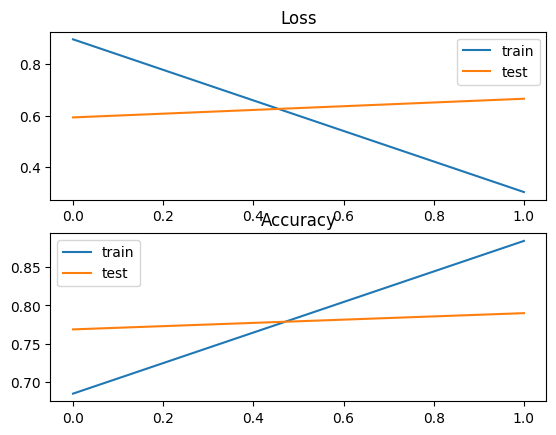

In [ ]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
history = model.fit(train_dataset, epochs=5, validation_data=test_dataset)

# Evaluate the model
train_loss, train_acc = model.evaluate(train_dataset, verbose=0)
test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
print("Train Accuracy: {:.3f}".format(train_acc))
print("Test Accuracy: {:.3f}".format(test_acc))

# Calculate F1 Macro Score
y_pred_logits = model.predict(test_dataset)
y_pred = np.argmax(y_pred_logits.logits, axis=1)

f1_macro = f1_score(y_test, y_pred, average="macro")
print("F1 macro score:", f1_macro)

Epoch 1/5
588/588 [==============================] - 201s 342ms/step - loss: 0.1553 - accuracy: 0.9422 - val_loss: 0.8093 - val_accuracy: 0.7928
Epoch 2/5
588/588 [==============================] - 211s 359ms/step - loss: 0.0903 - accuracy: 0.9687 - val_loss: 0.7777 - val_accuracy: 0.8031
Epoch 3/5
588/588 [==============================] - 211s 359ms/step - loss: 0.0579 - accuracy: 0.9807 - val_loss: 0.8507 - val_accuracy: 0.8069
Epoch 4/5
588/588 [==============================] - 212s 361ms/step - loss: 0.0357 - accuracy: 0.9885 - val_loss: 1.0098 - val_accuracy: 0.7860
Epoch 5/5
588/588 [==============================] - 211s 359ms/step - loss: 0.0283 - accuracy: 0.9924 - val_loss: 1.1628 - val_accuracy: 0.7813
Train Accuracy: 0.967
Test Accuracy: 0.781
74/74 [==============================] - 9s 116ms/step
F1 macro score: 0.7759087545806931


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [23]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_tfidf, y_train)
y_train_pred_rf = rf_clf.predict(X_train_tfidf)
y_test_pred_rf = rf_clf.predict(X_test_tfidf)

train_acc_rf = accuracy_score(y_train, y_train_pred_rf)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)

print("Random Forest Train Accuracy: {:.3f}".format(train_acc_rf))
print("Random Forest Test Accuracy: {:.3f}".format(test_acc_rf))


Random Forest Train Accuracy: 1.000
Random Forest Test Accuracy: 0.740


In [24]:
f1_macro_rf = f1_score(y_test, y_test_pred_rf, average="macro")
print("Random Forest F1 Macro Score:", f1_macro_rf)


Random Forest F1 Macro Score: 0.7451953880594875


In [25]:
from sklearn.metrics import classification_report

print("Random Forest Classification Report:\n")
print(classification_report(y_test, y_test_pred_rf))


Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.53      0.53       214
           1       0.62      0.60      0.61       217
           2       0.92      0.62      0.74       213
           3       1.00      0.99      0.99       222
           4       0.47      0.50      0.49       215
           5       0.99      1.00      0.99       211
           6       0.98      0.98      0.98       206
           7       0.72      0.62      0.67       220
           8       0.64      0.59      0.61       209
           9       0.49      0.73      0.59       217
          10       1.00      1.00      1.00       202

    accuracy                           0.74      2346
   macro avg       0.76      0.74      0.75      2346
weighted avg       0.76      0.74      0.74      2346



In [26]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.1 MB/s eta 0:00:00


In [27]:
from transformers import BertTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [28]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize_texts(texts):
    input_ids = []
    for text in texts:
        encoded_text = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=50, padding='max_length')
        input_ids.append(encoded_text)
    return np.array(input_ids)

X_train_tokenized = tokenize_texts(x_train)
X_test_tokenized = tokenize_texts(x_test)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_tokenized, y_train)

y_test_pred_rf = rf_clf.predict(X_test_tokenized)
print("Random Forest with BERT tokenizer Classification Report:\n")
print(classification_report(y_test, y_test_pred_rf))



Random Forest with BERT tokenizer Classification Report:

              precision    recall  f1-score   support

           0       0.16      0.14      0.14       214
           1       0.56      0.71      0.63       217
           2       0.43      0.48      0.45       213
           3       0.45      0.37      0.40       222
           4       0.19      0.17      0.18       215
           5       0.53      0.72      0.61       211
           6       0.20      0.20      0.20       206
           7       1.00      1.00      1.00       220
           8       0.18      0.15      0.17       209
           9       0.61      0.46      0.52       217
          10       0.64      0.70      0.67       202

    accuracy                           0.47      2346
   macro avg       0.45      0.46      0.45      2346
weighted avg       0.45      0.47      0.45      2346



In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)

    def call(self, x):
        q = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.nn.softmax(q, axis=1)
        return tf.reduce_sum(x * a, axis=1)


In [35]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen, weights=[embedding_matrix_tfidf]))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Attention())  # Attention layer
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(11, activation="softmax"))


In [42]:
batch_size = 64
epochs = 30
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train_padded, y_one_hot_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/30
118/118 [==============================] - 43s 250ms/step - loss: 1.5146 - accuracy: 0.4612 - val_loss: 1.1701 - val_accuracy: 0.5682
Epoch 2/30
118/118 [==============================] - 16s 140ms/step - loss: 1.0392 - accuracy: 0.6147 - val_loss: 0.9651 - val_accuracy: 0.6370
Epoch 3/30
118/118 [==============================] - 16s 134ms/step - loss: 0.8501 - accuracy: 0.6936 - val_loss: 1.0093 - val_accuracy: 0.6514
Epoch 4/30
118/118 [==============================] - 14s 116ms/step - loss: 0.6890 - accuracy: 0.7441 - val_loss: 0.9296 - val_accuracy: 0.6738
Epoch 5/30
118/118 [==============================] - 11s 96ms/step - loss: 0.5518 - accuracy: 0.7962 - val_loss: 0.9374 - val_accuracy: 0.6844
Epoch 6/30
118/118 [==============================] - 8s 67ms/step - loss: 0.4439 - accuracy: 0.8388 - val_loss: 1.1181 - val_accuracy: 0.6610
Epoch 7/30
118/118 [==============================] - 8s 71ms/step - loss: 0.3561 - accuracy: 0.8745 - val_loss: 1.1037 - val_accurac

In [43]:
from sklearn.metrics import classification_report

# Get the model's predictions
predictions = model.predict(X_test_padded)

# Convert predictions and true labels to one-hot vectors
y_pred_one_hot = np.argmax(predictions, axis=1)
y_test_one_hot = np.argmax(y_one_hot_tes, axis=1)

# Calculate the classification report
report = classification_report(y_test_one_hot, y_pred_one_hot)

print("Classification Report:\n", report)


74/74 [==============================] - 3s 10ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.50      0.53       214
           1       0.51      0.73      0.60       217
           2       0.49      0.55      0.52       213
           3       0.94      0.75      0.83       222
           4       0.48      0.54      0.51       215
           5       0.97      0.85      0.91       211
           6       0.83      0.97      0.89       206
           7       0.70      0.73      0.72       220
           8       0.42      0.22      0.29       209
           9       0.53      0.54      0.54       217
          10       0.96      0.95      0.96       202

    accuracy                           0.66      2346
   macro avg       0.67      0.67      0.66      2346
weighted avg       0.67      0.66      0.66      2346

